# Scattering Parameters (S-Parameters) 


## TODO: What are Scattering Parameters?






## TODO: Why are S-Parameters useful?


## TODO: Demonstration of using simphony to simulate a circuit quickly using s-parameters


## How to find S-Parameters for an arbitrary device using a meep simulation

In this section we'll demonstrate how to find the s-params for any device using a meep simulation. We'll show both 2D and 3D simulations, but keep in mind that 2D s-params are not very accurate. We'll run through the steps using gdsfactory's default 2x2 mmi, and explain on the way how the principles can be applied to any component. 

### Step 1 - Import Geometry

For our simulation, it makes life easy if we add all of our sources and detectors into our gds before we import it into meep. For this tutorial I have already done this. For your simulations, you can modify your gds file directly in Klayout if you like a GUI, or you can use gdsfactory itself. If you like, you can also use meep to do the same thing, but I won't be showing how to do that here. 

Here is a picture of the gds we will be using. 

![Image of splitter file](https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/mmi2x2_gds_with_ports.png)

I've added a box around the entire component (in purple) which will become the simulation region, and 8 lines, 2 on each end that will become the sources and detectors. I also added straight waveguides on the ports of the gdsfactory mmi so that my ports could be exactly where the light would enter and exit the component in an actual circuit. My sources are then slightly outside the mmi, in the waveguides.

So, now that we have a gds, lets import it into meep!

In [12]:
# Imports
import meep as mp 
import numpy
import matplotlib as plt 
import math

Next we'll define a whole bunch of variables so our code is more readable down the line. 

In [13]:
res = 50 # the resolution of the simulation in pixels/um
three_d = False # Turn this to false for a 2D simulation

gds_file = "mmi2x2.gds" # The name of our gds file

# Here we define the layer numbers for each part of our gds
geometry_L = 1
cell_L = 2
port1_L = 4
port2_L = 3
port3_L = 5
port4_L = 6
source1_L = 8
source2_L = 7
source3_L = 9
source4_L = 10

# The Parameters for the frequencies we'll be using
lcen = 1.55 # Center wavelength
fcen = 1 / lcen # Center frequency
df = 0.2*fcen # Frequency Diameter

# The thickness of each material in our simulation (only used in 3D simulations)
t_oxide = 1.0
t_Si = 0.22
t_air = 0.78

dpml = 1 # Diameter of perfectly matched layers
cell_thickness = dpml + t_oxide + t_Si + t_air + dpml # Cell thickness

# The materials we will have in our simulation, silicon and SiO2
oxide = mp.Medium(epsilon=2.25)
silicon = mp.Medium(epsilon=12)

# Sets the min and max values for the cell and the silicon. Our simulation will be centered at y=0
cell_zmax = 0.5*cell_thickness if three_d else 0
cell_zmin = -0.5 * cell_thickness if three_d else 0
si_zmax = 0.5 * t_Si if three_d else 10 # In a 2D simulation, the geometry still has to have a thickness or it won't show up
si_zmin = -0.5 * t_Si if three_d else -10

# Create a 2D array to hold the S-Parameters for the device
numPorts = 4 # The number of ports, also the size of our array
s_params = [[0 for i in range(numPorts)] for j in range(numPorts)]

Now, we'll import our geometries from the gds file

In [14]:
###################################################
# Now we actually import the geometry
geometry = mp.GDSII_prisms(silicon, gds_file, geometry_L, zmax=si_zmax, zmin=si_zmin) # Gets the geometry of the mmi
cell = mp.GDSII_vol(fname = gds_file, layer = cell_L, zmax=cell_zmax, zmin=cell_zmin) # cell geometry. We use mp.GDSII_vol() instead of mp.GDSII_prims() because they return different types
port1 = mp.GDSII_vol(fname = gds_file, layer = port1_L, zmax=cell_zmax, zmin=cell_zmin) # Port geometry
port2 = mp.GDSII_vol(fname = gds_file, layer = port2_L, zmax=cell_zmax, zmin=cell_zmin)
port3 = mp.GDSII_vol(fname = gds_file, layer = port3_L, zmax=cell_zmax, zmin=cell_zmin)
port4 = mp.GDSII_vol(fname = gds_file, layer = port4_L, zmax=cell_zmax, zmin=cell_zmin)
source1 = mp.GDSII_vol(fname = gds_file, layer = source1_L, zmax=cell_zmax, zmin=cell_zmin) # Source Geometry
source2 = mp.GDSII_vol(fname = gds_file, layer = source2_L, zmax=cell_zmax, zmin=cell_zmin)
source3 = mp.GDSII_vol(fname = gds_file, layer = source3_L, zmax=cell_zmax, zmin=cell_zmin)
source4 = mp.GDSII_vol(fname = gds_file, layer = source4_L, zmax=cell_zmax, zmin=cell_zmin)

if three_d: # Sets up the oxide cladding for a three d simulation (Not used in a 2D simulation)
    oxide_center = mp.Vector3(z=-0.5 * t_oxide)
    oxide_size = mp.Vector3(cell.size.x, cell.size.y, t_oxide)
    oxide_layer = [mp.Block(material=oxide, center=oxide_center, size=oxide_size)]
    geometry = geometry + oxide_layer

print(cell.size)
print(cell.center)

Vector3<35.5, 10.0, 0.0>
Vector3<0.0, 0.0, 0.0>


### Step 2: Run simulation for a single source

In order to find all the S-Parameters for a device, we have to run a simulation for each port. Each time we switch where the source is, and then get the S-parameters from that port. So, for this component, I'll run 4 simulations, each time injecting the light into a different port. Then I'll calculate the S-parameters between the port that has the light, and every other port. 

Because I added geometry for the sources in the gds, we just have to input that geometry into the source instead of constructing it in meep. 
TODO: Explain briefly why we use the eig_parity we do, and what the eig_band and eig_match_freq

Once we define the source in meep, we can create a simulation object by simply passing all of the necessary parts into the contructor. 

In [15]:
# Set up the first source for the simulation. I'll start with port1 (the lower left)
sources = [
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            size=source1.size, # Here we input the geometry for our first source
            center=source1.center,
            eig_band=1,
            eig_parity = mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq = True,

    )
]

# Create Simulation
sim = mp.Simulation(
    resolution=res, # The resolution, defined further up
    cell_size=cell.size, # The cell size, taken from the gds
    boundary_layers=[mp.PML(dpml)], # the perfectly matched layers, with a diameter as defined above
    sources = sources, # The source(s) we just defined
    geometry = geometry # The geometry, from above
)


After creating the simulation object, we can add mode monitors at each of the ports. These will read how much light comes in/out of each port. 

Now that our simulation is completely set up for the first source, I can plot it to make sure everything looks right before running the simulation. We do that using the plot2D() method of the simulation object.

     prism, center = (-7.75,-0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,-1.125,-10)
          (-12.75,-0.875,-10)
          (-12.75,-0.375,-10)
          (-2.75,-0.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (-7.75,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,0.125,-10)
          (-12.75,0.375,-10)
          (-12.75,0.875,-10)
          (-2.75,1.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (7.75,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (2.75,0.125,-10)
          (2.75,1.125,-10)
          (12.75,0.875,-10)
          (12.75,0.375,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (7.75,-0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (2.75,-1.125,-10)
      

/home/jkart/anaconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jkart/anaconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


<Axes: xlabel='X', ylabel='Y'>

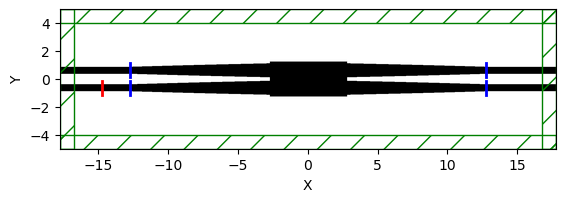

In [16]:
# Adds mode monitors at each of the ports to track the energy that goes in or out
modePort1 = sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port1))
modePort2 = sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port2))
modePort3 = sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port3))
modePort4 = sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port4))

# Plot the simulation
sim.plot2D()

As we see from the output of sim.plot2D(), our simulation is set up correctly. The red is our source, the blue are our 4 mode monitors, an the black is the geometry. We are ready to run the simulation! Actually running the simulation is the most computationally intense part of this, so it may take some time. The until_after_sources parameter for sim.run() means the run the simulation until 100 meep time units after the sources have turned off. This makes sure the all of the light has time to propagate through the mmi.

In [17]:
# Runs the simulation
sim.run(until_after_sources=100)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00560904 s
Working in 2D dimensions.
Computational cell is 35.5 x 10 x 0 with resolution 50
     prism, center = (-7.75,-0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,-1.125,-10)
          (-12.75,-0.875,-10)
          (-12.75,-0.375,-10)
          (-2.75,-0.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (-7.75,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,0.125,-10)
          (-12.75,0.375,-10)
          (-12.75,0.875,-10)
          (-2.75,1.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (7.75,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (2.75,0.125,-10)
          (2.75,1.125,-10)
          (12.75,0.875,-10)
          (12.75,0.375,-10)
          dielectric constant epsilon dia

Now that our simulation has been run, we'll quickly compute the s-parameters, store them in our array, and print them out. 

In [18]:
#############################################################
# Finds the S parameters
port1_coeff = sim.get_eigenmode_coefficients(modePort1, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, 0]
port2_coeff = sim.get_eigenmode_coefficients(modePort2, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, 0]
port3_coeff = sim.get_eigenmode_coefficients(modePort3, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, 0]
port4_coeff = sim.get_eigenmode_coefficients(modePort4, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, 0]

# Store the S parameters in s_params
s_params[0] = [port1_coeff, port2_coeff, port3_coeff, port4_coeff]


# Prints out the S parameters
print("\n-----------------------------------------------------------------\n")
print("S params: Port1(Lower Left, S11): {:.6f}  Port2(Upper Left, S12): {:.6f}  Port3(Upper Right, S13): {:.6f}  Port4(Lower Right, S14): {:.6f}".format(port1_coeff, port2_coeff, port3_coeff, port4_coeff))
print("\n-----------------------------------------------------------------\n")



MPB solved for frequency_1(2.2349,0,0) = 0.685305 after 21 iters
MPB solved for frequency_1(2.0913,0,0) = 0.645202 after 7 iters
MPB solved for frequency_1(2.09116,0,0) = 0.645161 after 1 iters
MPB solved for frequency_1(2.09116,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.091156,-0.000000,0.000000)
MPB solved for frequency_1(2.2349,0,0) = 0.685305 after 22 iters
MPB solved for frequency_1(2.0913,0,0) = 0.645202 after 7 iters
MPB solved for frequency_1(2.09116,0,0) = 0.645161 after 1 iters
MPB solved for frequency_1(2.09116,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.091156,-0.000000,0.000000)
MPB solved for frequency_1(2.2349,0,0) = 0.685305 after 22 iters
MPB solved for frequency_1(2.0913,0,0) = 0.645202 after 7 iters
MPB solved for frequency_1(2.09116,0,0) = 0.645161 after 1 iters
MPB solved for frequency_1(2.09116,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.091156,-0.000000,0.000000)
MPB solved for frequency_1(2.2349,0,0) =

Just for fun, we'll also compute and print the transmittance through each port and the total insertion loss. We won't do this with the other ports, but it's a good exercise here. 

We find that this component is actually terrible and would never be used in an actual photonic design. Almost a third of the light is lost, and the light that isn't lost is not split in any specific ratio. Fortunately, it was never meant to be used, and jsut exists as an example of the basic shape of an mmi.

In [19]:
# Calculates the transmittance based off of the S parameters
port2_trans = abs(port2_coeff) ** 2 / abs(port1_coeff) ** 2
port3_trans = abs(port3_coeff) ** 2 / abs(port1_coeff) ** 2
port4_trans = abs(port4_coeff) ** 2 / abs(port1_coeff) ** 2

# Calculates the Insertion loss as a percent and in dB
insertionLoss = 1-(port2_trans + port3_trans + port4_trans)
insertionLoss_dB = 10*math.log10(insertionLoss) 

# Prints the Transmittance
print("\n-----------------------------------------------------------------\n")
print("trans: Port2: {:.6f}%, Port3: {:.6f}%, Port4: {:.6f}%".format(port2_trans*100, port3_trans*100, port4_trans*100))
print("Insertion Loss: {:.6f}% -> {:.6f}db".format(insertionLoss*100, insertionLoss_dB))
print("\n-----------------------------------------------------------------\n")



-----------------------------------------------------------------

trans: Port2: 0.000022%, Port3: 6.601279%, Port4: 61.515984%
Insertion Loss: 31.882714% -> -4.964447db

-----------------------------------------------------------------



### Step 3: Run the same simulation for each of the other ports

Now, all that's left to do is to run the simulation for each source. Here, I'll use a for loop to run the other three simulations. We could have done this for all four, but hopefully this makes the code make more sense. 

For the sources going into port 3 and 4, we have to specify that the light will be propagating backwards. Below, I've done this by setting the direction to mp.NO_DIRECTION and using the eig_kpoint parameter to specify the direction. You can use this same method to launch sources in any direction

It should be noted, that since the 2x2 mmi we are using is symmetrical across both the x and y axies, the S-parameters should be the same for all of the other ports. But for the sake of demonstration, we'll simulate all of them. Then at then end we can check to see the the S-parameters are actually the same. 

In [20]:

# Set up the rest of the sources for the simulation. I'll start with port1 (the lower left)
sources = [
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            size=source2.size, # Here we input the geometry for our first source
            center=source2.center,
            eig_band=1,
            eig_parity = mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq = True,

    ),
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            size=source3.size, # Here we input the geometry for our first source
            center=source3.center,
            eig_band=1,
            eig_parity = mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq = True,
            eig_kpoint = mp.Vector3(-1,0,0),
            direction = mp.NO_DIRECTION

    ),
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            size=source4.size, # Here we input the geometry for our first source
            center=source4.center,
            eig_band=1,
            eig_parity = mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq = True,
            eig_kpoint = mp.Vector3(-1,0,0),
            direction = mp.NO_DIRECTION

    )
]

In [21]:

for i in range(numPorts-1) :

    source = sources[i:i+1]

    sim.reset_meep() # resets everything

    # Create Simulation
    sim = mp.Simulation(
    resolution=res, # The resolution, defined further up
    cell_size=cell.size, # The cell size, taken from the gds
    boundary_layers=[mp.PML(dpml)], # the perfectly matched layers, with a diameter as defined above
    sources = source, # The source(s) we just defined
    geometry = geometry # The geometry, from above
    )
    
    # Adds mode monitors at each of the ports to track the energy that goes in or out
    modePort1 = sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port1))
    modePort2 = sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port2))
    modePort3 = sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port3))
    modePort4 = sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port4))

    # Runs the simulation
    sim.run(until_after_sources=100)

    #############################################################
    # Finds the S parameters
    port1_coeff = sim.get_eigenmode_coefficients(modePort1, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, 0]
    port2_coeff = sim.get_eigenmode_coefficients(modePort2, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, 0]
    port3_coeff = sim.get_eigenmode_coefficients(modePort3, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, 0]
    port4_coeff = sim.get_eigenmode_coefficients(modePort4, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, 0]

    # Store the S parameters in s_params
    index = 1+i 
    s_params[index] = [port1_coeff, port2_coeff, port3_coeff, port4_coeff]

-----------
Initializing structure...
time for choose_chunkdivision = 0.00114989 s
Working in 2D dimensions.
Computational cell is 35.5 x 10 x 0 with resolution 50
     prism, center = (-7.75,-0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,-1.125,-10)
          (-12.75,-0.875,-10)
          (-12.75,-0.375,-10)
          (-2.75,-0.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (-7.75,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,0.125,-10)
          (-12.75,0.375,-10)
          (-12.75,0.875,-10)
          (-2.75,1.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (7.75,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (2.75,0.125,-10)
          (2.75,1.125,-10)
          (12.75,0.875,-10)
          (12.75,0.375,-10)
          dielectric constant epsilon dia

In [24]:
print("S-Params:")
for i in range(numPorts):
    print(f"S{i+1}1: {s_params[i][0]}  \tS{i+1}2: {s_params[i][1]}  \tS{i+1}3: {s_params[i][2]}  \tS{i+1}4: {s_params[i][3]}")


print("Transmission:")
for i in range(numPorts):
    trans1 = abs(s_params[i][0])**2 / abs(s_params[i][i])**2 * 100
    trans2 = abs(s_params[i][1])**2 / abs(s_params[i][i])**2 * 100
    trans3 = abs(s_params[i][2])**2 / abs(s_params[i][i])**2 * 100
    trans4 = abs(s_params[i][3])**2 / abs(s_params[i][i])**2 * 100
    print("{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}".format(trans1, trans2, trans3, trans4))




S-Params:
S11: (2.073837079339534+7.487298804641603j)  	S12: (-0.0021176313808567064-0.002975325519346291j)  	S13: (1.8619031796141472+0.7196374542480958j)  	S14: (-1.2433181680066065-5.96535673568779j)
S21: (-0.0021176318065006775-0.002975326579127314j)  	S22: (2.0738370289807277+7.487298838505997j)  	S23: (-1.2433182965094123-5.965357368445672j)  	S24: (1.8619016826998898+0.7196382157205293j)
S31: (-0.032441819136782596+0.002082615671862075j)  	S32: (0.00015036956999536785+0.0427242211640301j)  	S33: (0.1498160732597073+0.1807319667346948j)  	S34: (0.10283168723619183+0.35410857505000864j)
S41: (0.00015037021912440754+0.04272422705403925j)  	S42: (-0.032441813715602376+0.002082615800715164j)  	S43: (0.1028317274169818+0.3541085549307365j)  	S44: (0.14981620140746998+0.1807331866788009j)
Transmission:
100.000000	0.000022	6.601279	61.515984
0.000022	100.000000	61.515997	6.601272
1.917674	3.312317	100.000000	246.724648
3.312290	1.917656	246.722491	100.000000


S-Params:
S11: (2.0738370303823945+7.487298837279579j)  
S12: (-0.0021176313794123163-0.002975325509574002j)  
S13: (1.8619031796472698+0.7196374547358088j)  
S14: (-1.243318391719618-5.965357827133975j)

S21: (-0.0021176318065006775-0.002975326579127314j)  same as 12
S22: (2.073837028980713+7.487298838505995j)  same as 11
S23: (-1.2433182965094123-5.965357368445672j)  
S24: (1.8619044512481993+0.7196367614472267j)

S31: (0.0005679002481562931-0.00011512741373849618j)  
S32: (0.00019709752311403364-0.0008155852182588672j)  
S33: (-0.0016502616895469194-0.004969999629734143j)  should be 22
S34: (-0.0008691803285564012-0.007286991706124535j)

S41: (0.00019709027421615602-0.0008155855866727443j)  
S42: (0.0005678997056942723-0.00011512281425641433j)  
S43: (-0.0008692200218244908-0.00728697581362843j)  
S44: (-0.0016503003316809823-0.0049699701912919595j) should be 22